In [1]:
import h5py as h5
import netCDF4 as nc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import cv2
import csv
from global_land_mask import globe 
import glob
import math
from tqdm import tqdm
import re
import seaborn as sns


In [2]:
# goci_sample = '/home/juneyonglee/gocirrs_backup/home/pmilab/Downloads/GK2B_GOCI2_L2_20210101_001530_LA_S006_Chl.nc'

# f = h5.File(goci_sample,'r+')
# a = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['CHL Image Pixel Values']
# a = list(a)
# np_a = np.array(a)
# np_a = np.where(np_a==-999.0, 0, np_a)
# dst = np_a

In [3]:
# dst.shape

In [4]:
# np_a.shape

In [5]:
# goci2_sample = '/home/ubuntu/문서/AY_ust/chl_sample/goci2/GK2_GC2_L2_20210301_011530/GK2B_GOCI2_L2_20210301_011530_LA_S000_Chl.nc'
# f = nc.Dataset(goci2_sample,'r')
# a= f['geophysical_data']['Chl'][:].data
# np_a = np.array(a)
# np_a = np.where(np_a==-999.0, 0, np_a)
# np_a.shape

In [6]:
from scipy import io
mat_file = io.loadmat('/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.mat')
land_mask = mat_file['Land']

land_mask.shape

(8000, 10500)

In [10]:
import h5py

def check_with_h5py(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
            print("File opened successfully with h5py.")
            # 파일 내부의 키(데이터셋 구조) 출력
            print("File keys: ", list(f.keys()))
            # 필요한 경우 첫 번째 데이터셋의 세부 정보 확인
            first_key = list(f.keys())[0]
            dataset = f[first_key]
            print(f"Dataset '{first_key}' shape: {dataset.shape}")
            print(f"Dataset '{first_key}' data type: {dataset.dtype}")
    except OSError as e:
        print(f"Failed to open file with h5py: {e}")

# h5py로 파일 열기 시도
file_path = '/home/juneyonglee/Downloads/AQUA_MODIS.20140813_20140820.L3m.8D.CHL.chlor_a.4km.nc'
check_with_h5py(file_path)


File opened successfully with h5py.
File keys:  ['chlor_a', 'eightbitcolor', 'lat', 'lon', 'palette', 'processing_control', 'rgb']
Dataset 'chlor_a' shape: (4320, 8640)
Dataset 'chlor_a' data type: float32


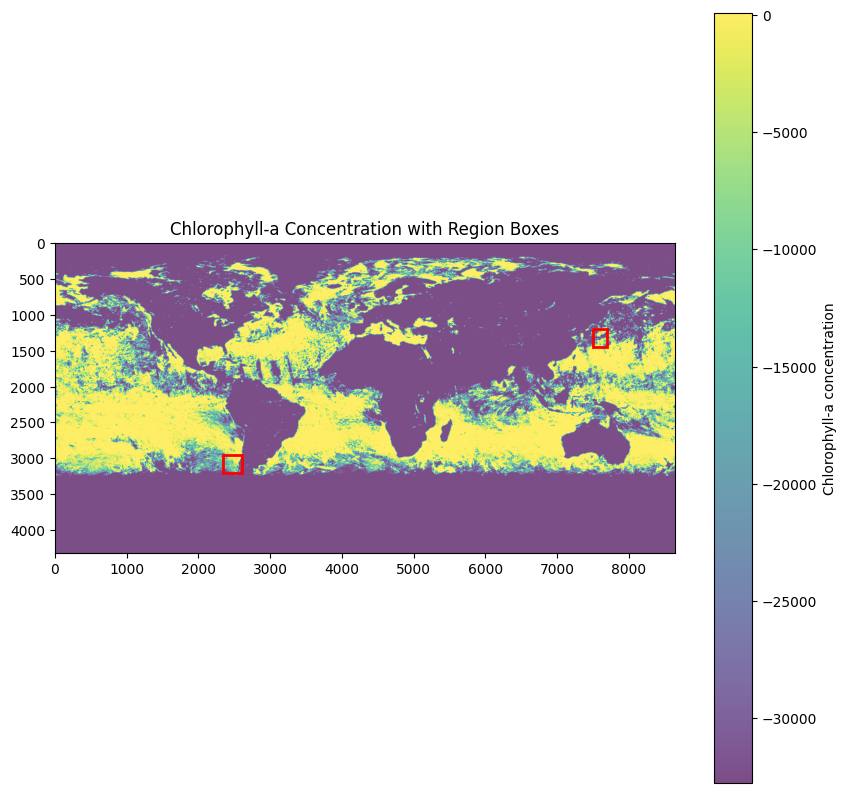

In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# MODIS 파일 경로
file_path = '/home/juneyonglee/Documents/MODIS_8day/AQUA_MODIS.20120703_20120710.L3m.8D.CHL.chlor_a.4km.nc'

# 낙동강 좌표 설정 (픽셀 좌표)
region1_x_min, region1_x_max = 2346, 2602
region1_y_min, region1_y_max = 2953, 3209
# # 새만금 좌표 설정 (픽셀 좌표)
# region2_x_min, region2_x_max = 1861, 2117
# region2_y_min, region2_y_max = 2659, 2915

# 대한민국 찾기 
region2_x_min, region2_x_max = 7500, 7700
region2_y_min, region2_y_max = 1200, 1450

def display_modis_chlor_a(file_path, region1_x_min, region1_x_max, region1_y_min, region1_y_max, 
                          region2_x_min, region2_x_max, region2_y_min, region2_y_max):
    # h5py로 파일 열기
    try:
        with h5py.File(file_path, 'r') as f:
            # chlor_a 데이터 읽기
            chlor_a_data = f['chlor_a'][:]
    except OSError as e:
        print(f"Failed to open file: {file_path}")
        return

    # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
    chlor_a_data = np.where(chlor_a_data == -999.0, np.nan, chlor_a_data)

    # 이미지 출력
    plt.figure(figsize=(10, 10))
    
    # chlor_a 데이터 이미지
    plt.imshow(chlor_a_data, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Chlorophyll-a concentration')

    # 낙동강 영역에 빨간색 사각형 추가
    rect1 = Rectangle((region1_x_min, region1_y_min), region1_x_max - region1_x_min, region1_y_max - region1_y_min,
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect1)

    # 새만금 영역에 빨간색 사각형 추가
    rect2 = Rectangle((region2_x_min, region2_y_min), region2_x_max - region2_x_min, region2_y_max - region2_y_min,
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect2)

    plt.title('Chlorophyll-a Concentration with Region Boxes')
    plt.show()


# chlor_a 데이터와 새만금 및 낙동강 좌표 범위에 네모 박스 표시
display_modis_chlor_a(file_path, region1_x_min, region1_x_max, region1_y_min, region1_y_max, 
                      region2_x_min, region2_x_max, region2_y_min, region2_y_max)


In [23]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_data(file_path):
    """Load chlorophyll-a data from an HDF5 file using h5py."""
    with h5py.File(file_path, 'r') as f:
        # Assuming the chlorophyll-a data is stored under 'chlor_a', adjust this if the dataset name is different
        chlor_a = f['chlor_a'][:]
    return chlor_a

def crop_region(data, pixel_region):
    """Crop the data to the given pixel region."""
    y_min, y_max = pixel_region['y_min'], pixel_region['y_max']
    x_min, x_max = pixel_region['x_min'], pixel_region['x_max']
    
    # Crop the data based on the pixel indices
    data_cropped = data[y_min:y_max, x_min:x_max]
    
    return data_cropped

def lat_lon_to_pixel(lat, lon):
    """Convert latitude and longitude to pixel coordinates in a 4320x8640 MODIS grid."""
    y_pixel = int((90 - lat) / 180 * 4320)
    x_pixel = int((lon + 180) / 360 * 8640)
    return y_pixel, x_pixel

def save_patch(data, region_name, x_min, x_max, y_min, y_max, output_path):
    """Save a 256x256 patch as a .png file."""
    patch = data[y_min:y_max, x_min:x_max]
    plt.imshow(patch, cmap='jet', vmin=0.01, vmax=20)
    plt.colorbar(label='Chlorophyll-a (mg m^-3)')
    plt.title(f'Chlorophyll-a Concentration ({region_name})')
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()

def main(file_path, idate):
    # Output directory 설정
    odir = f"output/fig/{idate.year}/{idate.month:02d}"
    os.makedirs(odir, exist_ok=True)

    # 데이터 로드
    chlor_a = load_data(file_path)

    # 낙동강 (Nakdong River) 영역
    nakdong_lat_min, nakdong_lat_max = 35.1, 36.2
    nakdong_lon_min, nakdong_lon_max = 128.5, 129.5
    nakdong_y_min, nakdong_x_min = lat_lon_to_pixel(nakdong_lat_max, nakdong_lon_min)
    nakdong_y_max, nakdong_x_max = lat_lon_to_pixel(nakdong_lat_min, nakdong_lon_max)

    # 새만금 (Saemangeum) 영역
    saemangeum_lat_min, saemangeum_lat_max = 35.4, 36.0
    saemangeum_lon_min, saemangeum_lon_max = 126.4, 127.0
    saemangeum_y_min, saemangeum_x_min = lat_lon_to_pixel(saemangeum_lat_max, saemangeum_lon_min)
    saemangeum_y_max, saemangeum_x_max = lat_lon_to_pixel(saemangeum_lat_min, saemangeum_lon_max)

    # 256x256 패치 추출 및 저장
    patch_size = 256
    # Center of Nakdong region
    nakdong_center_y = (nakdong_y_min + nakdong_y_max) // 2
    nakdong_center_x = (nakdong_x_min + nakdong_x_max) // 2
    nakdong_patch_region = {
        'y_min': nakdong_center_y - patch_size // 2,
        'y_max': nakdong_center_y + patch_size // 2,
        'x_min': nakdong_center_x - patch_size // 2,
        'x_max': nakdong_center_x + patch_size // 2
    }

    # Center of Saemangeum region
    saemangeum_center_y = (saemangeum_y_min + saemangeum_y_max) // 2
    saemangeum_center_x = (saemangeum_x_min + saemangeum_x_max) // 2
    saemangeum_patch_region = {
        'y_min': saemangeum_center_y - patch_size // 2,
        'y_max': saemangeum_center_y + patch_size // 2,
        'x_min': saemangeum_center_x - patch_size // 2,
        'x_max': saemangeum_center_x + patch_size // 2
    }

    # 낙동강 영역 패치 저장
    nakdong_output_path = f'{odir}/{idate.strftime("%Y%m%d")}_Nakdong_patch.png'
    save_patch(chlor_a, 'Nakdong River', **nakdong_patch_region, output_path=nakdong_output_path)

    # 새만금 영역 패치 저장
    saemangeum_output_path = f'{odir}/{idate.strftime("%Y%m%d")}_Saemangeum_patch.png'
    save_patch(chlor_a, 'Saemangeum', **saemangeum_patch_region, output_path=saemangeum_output_path)

if __name__ == "__main__":
    # 실제 사용하는 HDF5 파일 경로
    file_path ='/home/juneyonglee/Documents/MODIS_8day/AQUA_MODIS.20120703_20120710.L3m.8D.CHL.chlor_a.4km.nc'
    # file_path ='/home/juneyonglee/Documents/MODIS_8day/AQUA_MODIS.20130821_20130828.L3m.8D.CHL.chlor_a.4km.nc'
    # file_path ='/home/juneyonglee/Documents/MODIS_8day/AQUA_MODIS.20140813_20140820.L3m.8D.CHL.chlor_a.4km.nc'
    """
    AQUA_MODIS.20140813_20140820.L3m.8D.CHL.chlor_a.4km.nc
    AQUA_MODIS.20130821_20130828.L3m.8D.CHL.chlor_a.4km.nc
    AQUA_MODIS.20120703_20120710.L3m.8D.CHL.chlor_a.4km.nc
    """
    # 날짜 설정 (이미지에 날짜 표시를 위한 예시)
    idate = pd.to_datetime('2012-07-03')
    
    # main 함수 실행
    main(file_path, idate)



In [26]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the directory where PNG files are stored
directory = "/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig"

# List all PNG files in the directory and print their paths
png_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.png')]

# Print all PNG file paths
for png_file in png_files:
    print(png_file)

# Function to display images
def display_images(png_files):
    for png_file in png_files:
        img = Image.open(png_file)
        plt.figure()
        plt.imshow(img)
        plt.title(os.path.basename(png_file))
        plt.axis('off')  # Hide axes for better viewing
        plt.show()

# Display the images
display_images(png_files)
